This will be a notebook for investigating the \[\[7,1,3\]\] color code. This is a 2D color code. I will be using the paper from quantinuum for references to quantum circuits. \
We can first start by preparing the logical qubit basis state. This circuit will prepare the logical basis state $\ket{0}_L$ which corresponds to the state/code word:
$$ \ket{0}_L = \frac{1}{\sqrt{8}}\left(\ket{0000000> + |1010101> + |0110011> + |1100110> + |0001111> + |1011010> + |0111100> + |1101001}\right)$$
Note that Qiskit uses little-endianness whereas this state uses big-endianness, meaning the order of the 1's and 0's are reversed. So, we're actually preparing a state which is written as the reverse of each of these individual states.

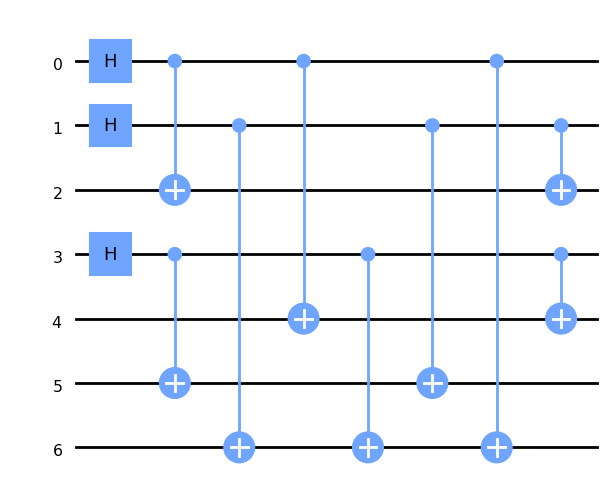

In [259]:
# encoding circuit to create the logical basis states
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

qreg_q = QuantumRegister(7, '')

encodingcircuit = QuantumCircuit(qreg_q)
encodingcircuit.h(qreg_q[0])
encodingcircuit.h(qreg_q[1])
encodingcircuit.h(qreg_q[3])
encodingcircuit.cx(qreg_q[0], qreg_q[2])
encodingcircuit.cx(qreg_q[3], qreg_q[5])
encodingcircuit.cx(qreg_q[1], qreg_q[6])
encodingcircuit.cx(qreg_q[0], qreg_q[4])
encodingcircuit.cx(qreg_q[3], qreg_q[6])
encodingcircuit.cx(qreg_q[1], qreg_q[5])
encodingcircuit.cx(qreg_q[0], qreg_q[6])
encodingcircuit.cx(qreg_q[1], qreg_q[2])
encodingcircuit.cx(qreg_q[3], qreg_q[4])
encodingcircuit.draw('mpl')
#@columns [0,0,0,1,1,2,3,3,4,5,6]

This circuit was taken from the paper from Quantinuum. Note that the 8th qubit and CNOTS going to it are for measuring the encoded state. \
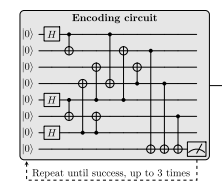 \
We can now measure the encoded state using the rest of the circuit given to see what values result. However we first want to create a general gate that represents the encoding circuit so we can append other quantum circuits to it: 

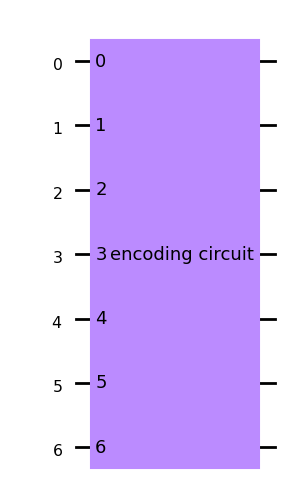

In [260]:
encodeGate = encodingcircuit.to_instruction(label='encoding circuit')

testcircuit = QuantumCircuit(qreg_q)
testcircuit.append(encodeGate, qreg_q) # add the encoding circuit to the new circuit
testcircuit.draw('mpl')

Lets test this circuit to make sure it outputs the desired statevector/code word, up to a change of endianness (see first text block):

In [261]:
from qiskit.quantum_info import Operator, Statevector

import numpy as np
from scipy import sparse

# returns the output statevector of the given circuit
statevec = Statevector.from_instruction(encodingcircuit)

# the statevector is very sparse, so we use a sparse matrix
# resepresentation in such cases to speed up calculations
# statevec_spmatrix = np.array(statevec).to_spmatrix()
statevec_spmatrix = sparse.csr_matrix(np.array(statevec))
indices = sparse.find(statevec_spmatrix)[1]
values = np.abs(sparse.find(statevec_spmatrix)[2])
print(indices)
print(values)

# quick script to convert the indices to their binary representation:
expected_reprs = ["0000000", "1010101", "0110011", "1100110", "0001111", "1011010", "0111100", "1101001"]

bin_indices = []
bin_reprs = []
for i in indices:
    bin_indices = np.append(bin_indices, bin(i))
    bin_repr = np.binary_repr(i,7)[::-1]
    bin_reprs.append(bin_repr)
    print(f"|{bin_repr}> ({'' if bin_repr in expected_reprs else 'not '}in expected logical state)")

for expected_repr in expected_reprs:
    if expected_repr not in bin_reprs:
        print(f"expected term |{expected_repr}> not in encoded logical state")

[  0  30  45  51  75  85 102 120]
[0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]
|0000000> (in expected logical state)
|0111100> (in expected logical state)
|1011010> (in expected logical state)
|1100110> (in expected logical state)
|1101001> (in expected logical state)
|1010101> (in expected logical state)
|0110011> (in expected logical state)
|0001111> (in expected logical state)


The actual resultant statevector may not seem to match up with the exected logical $\ket{0_L}$, but this is simply due to reverse endianness, which we correct by reversing the strings before verifying that our resultant logical state matches the expected logical state. A good sanity check for something like this is to check if it is an eigenvector of the stabilizers. 
 

XXXXIII (logical state is an eigenstate)
IXXIIXX (logical state is an eigenstate)
XIXIXIX (logical state is an eigenstate)
ZZZZIII (logical state is an eigenstate)
IZZIIZZ (logical state is an eigenstate)
ZIZIZIZ (logical state is an eigenstate)
stabilizers 'XXXXIII' and 'IXXIIXX'  commute
stabilizers 'XXXXIII' and 'XIXIXIX'  commute
stabilizers 'XXXXIII' and 'ZZZZIII'  commute
stabilizers 'XXXXIII' and 'IZZIIZZ'  commute
stabilizers 'XXXXIII' and 'ZIZIZIZ'  commute
stabilizers 'IXXIIXX' and 'XIXIXIX'  commute
stabilizers 'IXXIIXX' and 'ZZZZIII'  commute
stabilizers 'IXXIIXX' and 'IZZIIZZ'  commute
stabilizers 'IXXIIXX' and 'ZIZIZIZ'  commute
stabilizers 'XIXIXIX' and 'ZZZZIII'  commute
stabilizers 'XIXIXIX' and 'IZZIIZZ'  commute
stabilizers 'XIXIXIX' and 'ZIZIZIZ'  commute
stabilizers 'ZZZZIII' and 'IZZIIZZ'  commute
stabilizers 'ZZZZIII' and 'ZIZIZIZ'  commute
stabilizers 'IZZIIZZ' and 'ZIZIZIZ'  commute


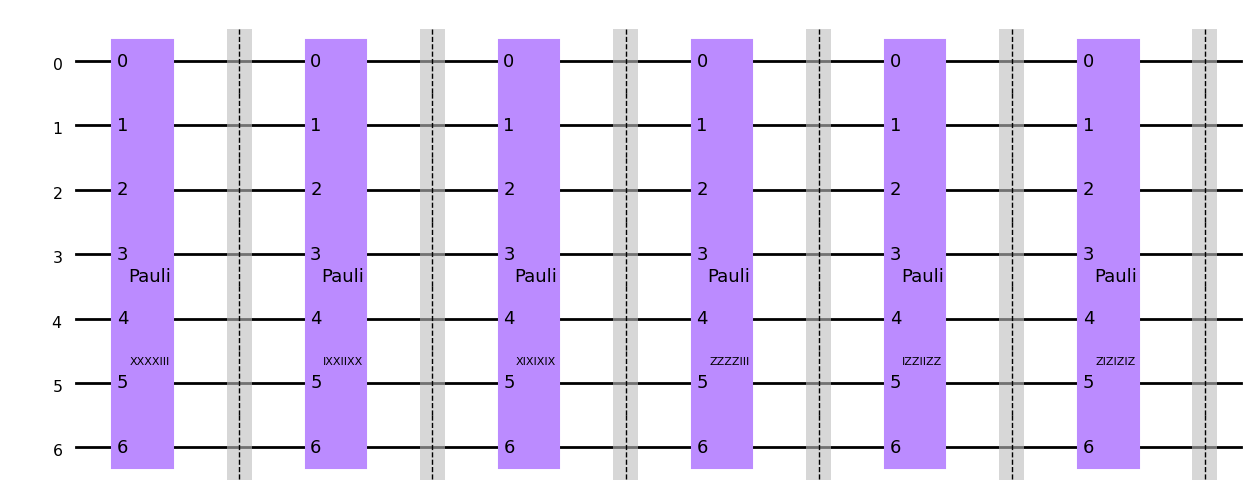

In [265]:
stabilizer_strings = [
    "XXXXIII",
    "IXXIIXX",
    "XIXIXIX",
    "ZZZZIII",
    "IZZIIZZ",
    "ZIZIZIZ"
]

stabilizer_circuits = []

compiled_stabilizercircuit = QuantumCircuit(qreg_q)
for stabilizer_string in stabilizer_strings:
    stabilizercircuit = QuantumCircuit(qreg_q)
    stabilizercircuit.pauli(stabilizer_string, qreg_q)
    stabilizercircuit.barrier(qreg_q)

    # check that logical zero vector is an eigenstate of this stabilizer
    test_statevec = Statevector.from_instruction(encodingcircuit) # encode statevector
    tested_statevec = Statevector.from_instruction(encodingcircuit).evolve(stabilizercircuit) # apply this stabilizer
    print(f"{stabilizer_string} (logical state is {'' if tested_statevec.equiv(test_statevec) else 'not '}an eigenstate)")

    stabilizer_circuits.append(stabilizercircuit)
    compiled_stabilizercircuit &= stabilizercircuit

for si in range(len(stabilizer_circuits)-1):
    stabilizer_i = Operator(stabilizer_circuits[si])

    for sj in range(si+1, len(stabilizer_circuits)):
        stabilizer_j = Operator(stabilizer_circuits[sj])

        commutator = stabilizer_i.compose(stabilizer_j) - stabilizer_j.compose(stabilizer_i)
        commutes = stabilizer_i.compose(stabilizer_j) == stabilizer_j.compose(stabilizer_i)
        print(f"stabilizers '{stabilizer_strings[si]}' and '{stabilizer_strings[sj]}' {'' if commutes else 'do not'} commute")

compiled_stabilizercircuit.draw("mpl")

Now we can measure the encoding circuit using the 3 CNOTs. This constitutes a measurement in the logical Z basis.

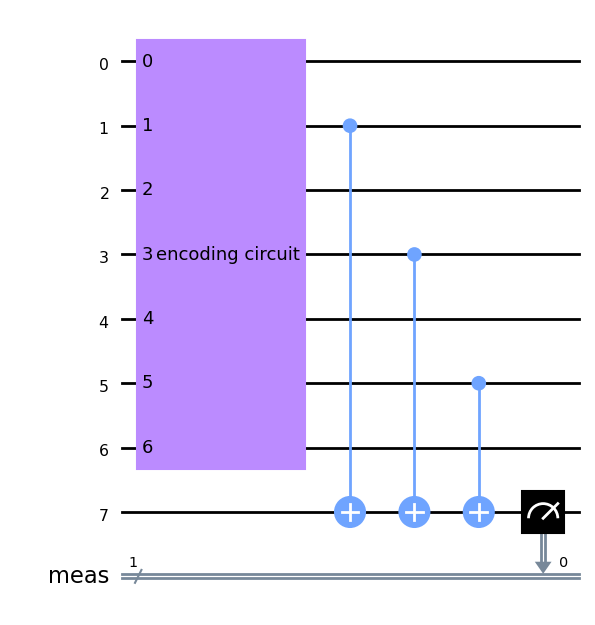

In [263]:
qreg_m = QuantumRegister(8, '')
creg_m = ClassicalRegister(1, name='meas')
meascircuit = QuantumCircuit(qreg_m, creg_m)
meascircuit.append(encodeGate, qreg_m[:7])
meascircuit.cx(control_qubit=qreg_m[1], target_qubit=qreg_m[7])
meascircuit.cx(control_qubit=qreg_m[3], target_qubit=qreg_m[7])
meascircuit.cx(control_qubit=qreg_m[5], target_qubit=qreg_m[7])
meascircuit.measure(7, 0)
meascircuit.draw('mpl')